###1. Data Preparation:

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

# Load the Kuzushiji-MNIST dataset
(ds_train, ds_test), ds_info = tfds.load('kmnist', split=['train', 'test'], shuffle_files=True, as_supervised=True, with_info=True)

# Function to normalize images
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255.0, label

# Normalize and batch the datasets
batch_size = 32
ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.shuffle(1000).batch(batch_size)

ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(batch_size)

# Convert datasets to NumPy arrays
def dataset_to_numpy(dataset):
    X, y = [], []
    for images, labels in dataset:
        X.extend(images.numpy())
        y.extend(labels.numpy())
    return np.array(X), np.array(y)

# Convert training and test datasets to NumPy arrays
X_train, y_train = dataset_to_numpy(ds_train)
X_test, y_test = dataset_to_numpy(ds_test)

# Split the training data into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)






###2. Radial Basis Function (RBF) Network:

In [3]:
# Flatten the images to shape (batch_size, 784)
X_train = X_train.reshape(-1, 784)
X_val = X_val.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

# Determine the centers using K-means clustering
num_units = 100  # Number of RBF units
kmeans = KMeans(n_clusters=num_units, random_state=42).fit(X_train)
centers = kmeans.cluster_centers_

# Define the RBF Network class
class RBFNetwork(tf.keras.Model):
    def __init__(self, num_units, num_classes, centers):
        super(RBFNetwork, self).__init__()
        self.num_units = num_units
        self.num_classes = num_classes
        self.centers = tf.Variable(centers, trainable=False)  # Set the centers from K-means
        self.beta = tf.Variable(tf.ones([self.num_units]), trainable=True)  # Trainable beta
        self.W = tf.Variable(tf.random.normal([self.num_units, self.num_classes]))  # Weights for output layer

    def rbf(self, X):
        # Compute the Gaussian RBF
        diff = tf.expand_dims(X, 1) - tf.expand_dims(self.centers, 0)
        distance_squared = tf.reduce_sum(tf.square(diff), axis=-1)
        return tf.exp(-self.beta * distance_squared)

    def call(self, X):
        rbf_output = self.rbf(X)
        return tf.nn.softmax(tf.matmul(rbf_output, self.W))

# Create the RBF network instance
num_classes = 10  # Number of classes (0-9)
rbf_network = RBFNetwork(num_units, num_classes, centers)

# Compile the model with gradient descent optimizer
learning_rate = 0.01
rbf_network.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                    metrics=['accuracy'])

###3. Training:

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.0986 - loss: 2.3026 - val_accuracy: 0.1008 - val_loss: 2.3026
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.0988 - loss: 2.3026 - val_accuracy: 0.1008 - val_loss: 2.3026
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.0990 - loss: 2.3026 - val_accuracy: 0.1008 - val_loss: 2.3026
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.1014 - loss: 2.3026 - val_accuracy: 0.1008 - val_loss: 2.3026
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.0996 - loss: 2.3026 - val_accuracy: 0.1008 - val_loss: 2.3026
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.0994 - loss: 2.3026 - val_accuracy: 0.1008 - val_loss: 2.3026
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.1001 - loss: 2.3026 - val_accuracy: 0.1008 - val_loss: 2.3026
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.1020 - loss: 2.3026 - val_ac

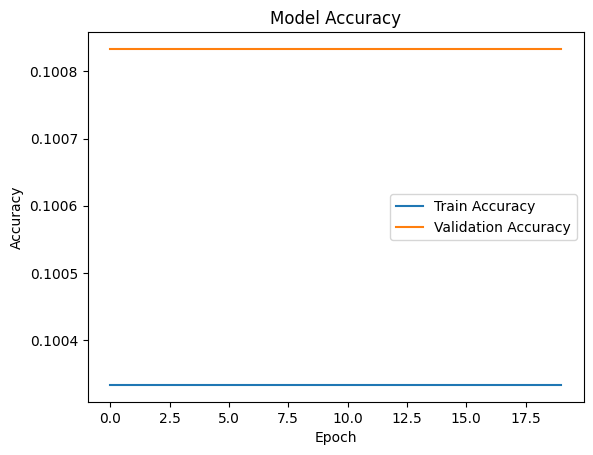

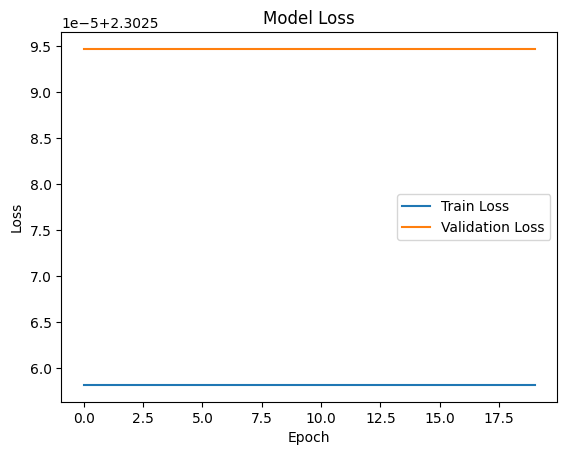

In [4]:
# Train the model for 20 epochs
history = rbf_network.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20)

# Evaluate the model on the test set
test_loss, test_accuracy = rbf_network.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Print final training accuracy
final_train_accuracy = history.history['accuracy'][-1]  # Get the last training accuracy value
print("Final Training Accuracy:", final_train_accuracy)

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

###4. Evaluation:

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


<Figure size 1000x700 with 0 Axes>

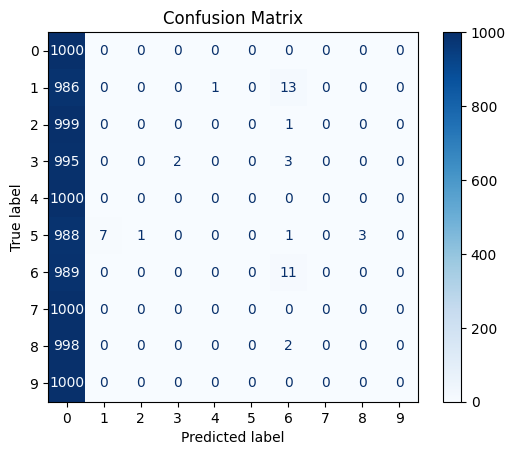

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = np.argmax(rbf_network.predict(X_test), axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(num_classes)).plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()



###5. Analysis:

# Analysis of RBF Network for Kuzushiji-MNIST Dataset

## Strengths
1. **Simplicity:** RBF networks are easy to interpret and understand.
2. **Non-Linear Modeling:** Effective for capturing non-linear relationships in data.
3. **Good Generalization:** When tuned properly, they generalize well to unseen data.
4. **Fast Training:** Training can be efficient, especially with fewer training samples.
5. **Locality:** RBFs focus on local regions, helping to handle data variations.

## Limitations
1. **Hyperparameter Sensitivity:** Performance depends heavily on the choice of hyperparameters like the number of units and spread (beta).
2. **Curse of Dimensionality:** Performance can degrade in high-dimensional spaces.
3. **Data Limitations:** May struggle with complex datasets or high-resolution images.
4. **Scalability Issues:** Larger datasets require more centers, complicating training.
5. **Complexity:** Requires careful management of the number of units to avoid overfitting or underfitting.

## Impact of RBF Units on Performance
- **Underfitting:** Too few units can lead to oversimplification and high error rates.
- **Overfitting:** Too many units can cause memorization of training data, lowering generalization.
- **Complexity vs. Efficiency:** More units increase model capacity but also computational demands.
- **Optimal Tuning:** Experimentation and validation are key to finding the right number of units, balancing performance and complexity.

## Conclusion
RBF networks offer interpretability and non-linear modeling capabilities, but careful tuning of hyperparameters and consideration of the number of units are crucial for effective performance on the Kuzushiji-MNIST dataset.

